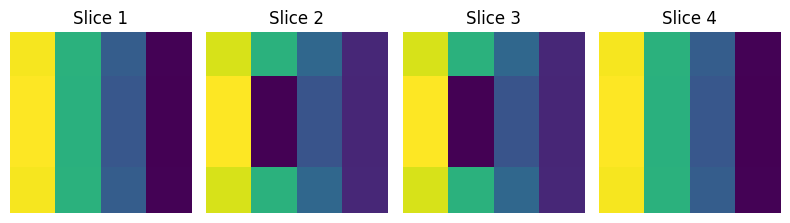

[[-5.0 ,1.0 ,0.0 ,0.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,],
[1.0 ,-4.0 ,1.0 ,0.0 ,0.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,],
[0.0 ,1.0 ,-4.0 ,1.0 ,0.0 ,0.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,],
[0.0 ,0.0 ,1.0 ,-5.0 ,0.

In [18]:
%run darcy_solver.ipynb

In [35]:
%run ..\src\volumeManager
#VolumeManager

In [31]:
import porespy as ps

In [3]:
vol = ps.generators.blobs(shape=(100, 100, 100), porosity=0.35, seed=42)

In [4]:
import scipy as sc

In [5]:
lab, n_lab = sc.ndimage.label(vol)

In [6]:
print(np.unique(lab[0,:,:]))
print(np.unique(lab[-1,:,:]))
print(np.unique(lab[:,0,:]))
print(np.unique(lab[:,-1,:]))
print(np.unique(lab[:,:,0]))
print(np.unique(lab[:,:,-1]))

[0 1 2 3]
[ 0  1 33 36 37 38]
[ 0  1  5 10 16 29 32 33]
[ 0  1  8 11 13 18 23 26]
[ 0  1  3  6  8 13 18 20 33]
[ 0  1 12 14 16]


In [7]:
con_vol = (lab==1)

In [8]:
con_vol.sum() / con_vol.size

0.344097

In [19]:
def get_unravel_function(volume, nulls_count):
    def unravel(x, y, z):
        w, h, d = volume.shape
        i = z + y * d + x * d * h
        try:
            output = i - nulls_count[i]
        except:
            print(x, y, z)
            raise
        return output
    return unravel

def sparse_matrix_extractor(volume):

    nonzeros = np.count_nonzero(volume)
    diag_nulls_count = np.empty(volume.size, dtype=int)
    running_zeros = 0
    i = 0
    w, h, d = volume.shape
    for x, y, z in ((a,b,c) for a in range(w) for b in range(h) for c in range(d)):
        center_c = volume[x, y, z]
        if center_c > 0:
            diag_nulls_count[i] = running_zeros
            i += 1
        else:
            running_zeros += 1
            diag_nulls_count[i] = running_zeros
            i += 1
    
    neighbour_displacement_template = np.array((h*d, d, 1), dtype=int)
    
    val_array = np.zeros(nonzeros * 7)
    col_idx_array = np.zeros(nonzeros * 7, dtype=int)
    row_ptr_array = np.zeros(nonzeros, dtype=int)
    condensed_b = np.zeros(nonzeros)
    
    sparse_i = 0
    vals_n = 0

    unravel = get_unravel_function(volume, diag_nulls_count)
    for x, y, z in ((a,b,c) for a in range(w) for b in range(h) for c in range(d)):
        coords = np.array((x, y, z))
        center_c = volume[tuple(coords)]

        if center_c == 0:
            continue

        x_min = (x == 0)
        x_max = (x == w - 1)
        y_min = (y == 0)
        y_max = (y == h - 1)
        z_min = (z == 0)
        z_max = (z == d - 1)

        key = (x_min, x_max, y_min, y_max, z_min, z_max)
        neighbours = neighbours_dict[key]

        total_c = np.float32(0)

        if z_min:
            total_c += 2 * center_c
            condensed_b[unravel(x, y, z)] = -(2 * center_c)
        elif z_max:
            total_c += 2 * center_c

        center_i = unravel(x, y, z)
        row_ptr_array[center_i] = vals_n
        for neighbour in neighbours:
            neighbour_c = volume[tuple(coords + neighbour)]
            if neighbour_c == 0: continue
            face_c = 2 / (1 / center_c + 1 / neighbour_c)
            total_c += np.float32(face_c)
            neighbour_displacement = (neighbour_displacement_template * neighbour)
            neighbour_i = unravel(*tuple(coords + neighbour))
            #A[i, i + neighbour_displacement] = face_c
            val_array[vals_n] = face_c
            col_idx_array[vals_n] = neighbour_i
            vals_n += 1
        #A[i,i] = - total_c
        val_array[vals_n] = face_c
        col_idx_array[vals_n] = neighbour_i
        vals_n += 1

        i += 1
    sparse_array = {
    "val": val_array,
    "col_idx": col_idx_array,
    "row_ptr": row_ptr_array,
    }
    return sparse_array, condensed_b
        
#sparse_array_large, condensed_b_large = sparse_matrix_extractor(con_vol)


In [20]:
sparse_array_1, condensed_b_1 = sparse_matrix_extractor(volume)

In [21]:
condensed_b_1

array([-2.,  0.,  0.,  0., -2.,  0.,  0.,  0., -2.,  0.,  0.,  0., -2.,
        0.,  0.,  0., -2.,  0.,  0.,  0., -2.,  0.,  0., -2.,  0.,  0.,
       -2.,  0.,  0.,  0., -2.,  0.,  0.,  0., -2.,  0.,  0., -2.,  0.,
        0., -2.,  0.,  0.,  0., -2.,  0.,  0.,  0., -2.,  0.,  0.,  0.,
       -2.,  0.,  0.,  0., -2.,  0.,  0.,  0.])

In [22]:
condensed_b

array([-2.,  0.,  0.,  0., -2.,  0.,  0.,  0., -2.,  0.,  0.,  0., -2.,
        0.,  0.,  0., -2.,  0.,  0.,  0., -2.,  0.,  0., -2.,  0.,  0.,
       -2.,  0.,  0.,  0., -2.,  0.,  0.,  0., -2.,  0.,  0., -2.,  0.,
        0., -2.,  0.,  0.,  0., -2.,  0.,  0.,  0., -2.,  0.,  0.,  0.,
       -2.,  0.,  0.,  0., -2.,  0.,  0.,  0.])

In [23]:
sparse_array_1["val"]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.33333333, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.33333333,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [24]:
sparse_array["val"]

array([-5.        ,  1.        ,  1.        ,  1.        ,  1.        ,
       -4.        ,  1.        ,  1.        ,  1.        ,  1.        ,
       -4.        ,  1.        ,  1.        ,  1.        ,  1.        ,
       -5.        ,  1.        ,  1.        ,  1.        , -6.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
       -4.        ,  1.        ,  1.        ,  1.        ,  1.        ,
       -5.33333349,  1.        ,  1.        ,  1.33333337,  1.        ,
        1.        , -6.        ,  1.        ,  1.        ,  1.        ,
       -6.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        , -4.        ,  1.        ,  1.        ,  1.        ,
        1.        , -5.33333349,  1.        ,  1.        ,  1.33333337,
        1.        ,  1.        , -6.        ,  1.        ,  1.        ,
        1.        , -5.        ,  1.        ,  1.        ,  1.        ,
        1.        , -4.        ,  1.        ,  1.        ,  1.  

In [37]:
volume_manager = VolumeManager(con_vol)

In [38]:
A, b = volume_manager.get_sparse_system()

In [39]:
A

{'val': array([-5.,  1.,  1., ...,  1.,  1., -5.]),
 'col_idx': array([     0,      1,     50, ..., 344048, 344095, 344096]),
 'row_ptr': array([      0,       4,       9, ..., 2146531, 2146536, 2146541])}

In [40]:
b

array([-2.,  0.,  0., ...,  0.,  0.,  0.])

In [55]:
MAX_STEP = 1/4
STEP_ADJUSTMENT = 1/4
INITIAL_STEP = 1/8

X0 = np.linspace(0, 1, num=b.size, dtype=np.float32)
next_X = X0.copy
error = np.inf
step = INITIAL_STEP
residuals = calc_residuals(A, b, X0)

for i in range(1000):
    next_x = X0 - residuals * step
    next_residuals = calc_residuals(A, b, next_x)
    next_error = (next_residuals**2).sum()
    if next_error < error:
        residuals = next_residuals
        X0 = next_x
        error = next_error
        step += (MAX_STEP - step) * STEP_ADJUSTMENT
    else:
        step = 1/step
        step += (step - 1/MAX_STEP)
        step = 1/step
        
    print(i, next_error/X0.size, step)

0 0.05316219313703694 0.15625
1 0.020926856823348505 0.1796875
2 0.009812575474947835 0.197265625
3 0.005685362447534779 0.21044921875
4 0.003786309639682815 0.2203369140625
5 0.00274043606912622 0.227752685546875
6 0.0020937660548161203 0.23331451416015625
7 0.0016623911388676377 0.2374858856201172
8 0.0013589635041647505 0.2406144142150879
9 0.0011377238561296851 0.24296081066131592
10 0.0009747208753715795 0.24472060799598694
11 0.0008630543895167097 0.2460404559969902
12 0.0008234870865923162 0.24703034199774265
13 0.0009530292599974535 0.2441304067339356
14 0.0009427101312343431 0.23853010787420734
15 0.0009233735604247767 0.22806651459458568
16 0.0008893339694298592 0.2096712310499117
17 0.0008360891558591673 0.18054637834216597
18 0.0007689883896122042 0.1979097837566245
19 0.0007681658002344725 0.21093233781746837
20 0.0008735678356196164 0.18242471003577293
21 0.000747770550244099 0.19931853252682968
22 0.0008242869716163339 0.16572232918263813
23 0.000671227344829592 0.186791

KeyboardInterrupt: 

In [57]:
vol_40 = ps.generators.blobs(shape=(40, 40, 40), porosity=0.35, seed=42)
lab_40, n_lab_40 = sc.ndimage.label(vol)
print(np.unique(lab_40[0,:,:]))
print(np.unique(lab_40[-1,:,:]))
print(np.unique(lab_40[:,0,:]))
print(np.unique(lab_40[:,-1,:]))
print(np.unique(lab_40[:,:,0]))
print(np.unique(lab_40[:,:,-1]))

[0 1 2 3]
[ 0  1 33 36 37 38]
[ 0  1  5 10 16 29 32 33]
[ 0  1  8 11 13 18 23 26]
[ 0  1  3  6  8 13 18 20 33]
[ 0  1 12 14 16]


In [58]:
con_vol_40 = (lab_40==1)
con_vol_40.sum() / con_vol_40.size

0.344097

In [59]:
volume_manager_40 = VolumeManager(con_vol_40)
A_40, b_40 = volume_manager_40.get_sparse_system()

In [ ]:
MAX_STEP = 1/4
STEP_ADJUSTMENT = 1/4
INITIAL_STEP = 1/8

X0 = np.linspace(0, 1, num=b_40.size, dtype=np.float32)
next_X = X0.copy
error = np.inf
step = INITIAL_STEP
residuals = calc_residuals(A_40, b_40, X0)

for i in range(1000):
    next_x = X0 - residuals * step
    next_residuals = calc_residuals(A_40, b_40, next_x)
    next_error = (next_residuals**2).sum()
    if next_error < error:
        residuals = next_residuals
        X0 = next_x
        error = next_error
        step += (MAX_STEP - step) * STEP_ADJUSTMENT
    else:
        step = 1/step
        step += (step - 1/MAX_STEP)
        step = 1/step
        
    print(i, next_error/X0.size, step)

0 0.05316219313703694 0.15625
1 0.020926856823348505 0.1796875
2 0.009812575474947835 0.197265625
3 0.005685362447534779 0.21044921875
4 0.003786309639682815 0.2203369140625
5 0.00274043606912622 0.227752685546875
6 0.0020937660548161203 0.23331451416015625
7 0.0016623911388676377 0.2374858856201172
8 0.0013589635041647505 0.2406144142150879
9 0.0011377238561296851 0.24296081066131592
10 0.0009747208753715795 0.24472060799598694
11 0.0008630543895167097 0.2460404559969902
12 0.0008234870865923162 0.24703034199774265
13 0.0009530292599974535 0.2441304067339356
14 0.0009427101312343431 0.23853010787420734
15 0.0009233735604247767 0.22806651459458568
16 0.0008893339694298592 0.2096712310499117
17 0.0008360891558591673 0.18054637834216597
18 0.0007689883896122042 0.1979097837566245
19 0.0007681658002344725 0.21093233781746837
20 0.0008735678356196164 0.18242471003577293
21 0.000747770550244099 0.19931853252682968
22 0.0008242869716163339 0.16572232918263813
23 0.000671227344829592 0.186791